In [14]:
import numpy as np
import xarray as xr
import os.path as op
from dask.diagnostics import ProgressBar
from xgcm.grid import Grid as xgrid
from scipy.interpolate import interp1d
from xmitgcm import open_mdsdataset
from MITgcmutils import jmd95
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from xlayers import finegrid, layers
from xlayers.core import layers_numpy

In [3]:
ddir = '/tank/chaocean/'

In [4]:
xchunk = 500
for nmemb in range(4):
    if nmemb == 0:
        ds = open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run2012/ocn/' % nmemb), 
                             grid_dir = op.join(ddir,'grid_chaO/gridMIT_update1/'),
                             prefix = ['diag_ocnTave'], delta_t = 2e2
                            ).isel(time=0).chunk({'XC':xchunk,'XG':xchunk})
    else:
        ds = xr.concat([ds, open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run2012/ocn/' % nmemb), 
                                            grid_dir = op.join(ddir,'grid_chaO/gridMIT_update1/'),
                                            prefix = ['diag_ocnTave'], delta_t = 2e2
                                           ).isel(time=0).chunk({'XC':xchunk,'XG':xchunk})],
                      dim='time')
ds

/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/xmitgcm/mds_store.py:837: UserWarning: Couldn't find available_diagnostics.log in /tank/chaocean/qjamet/RUNS/ORAR/memb00/run2012/ocn/ or /tank/chaocean/grid_chaO/gridMIT_update1/. Using default version.
  "in %s or %s. Using default version." % (data_dir, grid_dir))
/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/xmitgcm/mds_store.py:217: FutureWarning: In xarray version 0.15 `auto_combine` will be deprecated. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi
  ds = xr.auto_combine(datasets)
/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/xmitgcm/mds_store.py:217: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the o

<xarray.Dataset>
Dimensions:  (XC: 1000, XG: 1000, YC: 900, YG: 900, Z: 46, Zl: 46, Zp1: 47, Zu: 46, time: 4)
Coordinates:
    dxG      (YG, XC) >f4 8993.141 8993.141 8993.141 ... 5493.54 5493.54 5493.54
    dyG      (YC, XG) >f4 9264.79 9264.79 9264.79 ... 9264.79 9264.79 9264.79
    iter     int64 8516880
    maskS    (Z, YG, XC) bool True True True True ... False False False False
    drF      (Z) >f4 6.0935454 6.721007 7.098827 ... 249.91599 250.46292
    PHrefF   (Zp1) >f4 0.0 59.77768 125.710754 ... 53954.938 56406.613 58863.656
    maskW    (Z, YC, XG) bool True True True True ... False False False False
    rAs      (YG, XC) >f4 83319550.0 83319550.0 ... 50896490.0 50896490.0
    hFacC    (Z, YC, XC) >f4 1.0 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    rAw      (YC, XG) >f4 83341540.0 83341540.0 ... 50843696.0 50843696.0
    maskC    (Z, YC, XC) bool True True True True ... False False False False
    maskInW  (YC, XG) bool False False False False ... False False False F

In [5]:
grid = xgrid(ds, periodic=['X'])
grid

<xgcm.Grid>
T Axis (not periodic):
  * center   time
Y Axis (not periodic):
  * center   YC --> left
  * left     YG --> center
X Axis (periodic):
  * center   XC --> left
  * left     XG --> center
Z Axis (not periodic):
  * center   Z --> left
  * left     Zl --> center
  * outer    Zp1 --> center
  * right    Zu --> center

In [6]:
rho2 = xr.apply_ufunc(jmd95.densjmd95, ds.SALT, ds.THETA, 20e2, 
                     dask='parallelized', output_dtypes=[float]
                     )
rho2y = xr.apply_ufunc(jmd95.densjmd95, grid.interp(ds.SALT,'Y',boundary='fill'), 
                      grid.interp(ds.THETA,'Y',boundary='fill'), 20e2, 
                      dask='parallelized', output_dtypes=[float]
                      )
rho2

<xarray.DataArray (time: 4, Z: 46, YC: 900, XC: 1000)>
dask.array<densjmd95, shape=(4, 46, 900, 1000), dtype=float64, chunksize=(1, 46, 900, 500), chunktype=numpy.ndarray>
Coordinates:
    iter     int64 8516880
    drF      (Z) >f4 6.0935454 6.721007 7.098827 ... 249.91599 250.46292
    hFacC    (Z, YC, XC) >f4 1.0 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    maskC    (Z, YC, XC) bool True True True True ... False False False False
    rA       (YC, XC) >f4 83341540.0 83341540.0 ... 50843696.0 50843696.0
    PHrefC   (Z) >f4 29.88884 92.74422 160.5305 ... 55180.777 57635.133
    Depth    (YC, XC) >f4 3440.756 3215.3306 2099.5483 ... 2916.6108 2823.8076
    maskInC  (YC, XC) bool False False False False ... False False False False
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * YC       (YC) >f4 -19.916634 -19.8333 -19.749968 ... 54.916702 55.000034
  * Z        (Z) >f4 -3.0467727 -9.454049 -16.363966 ... -5624.9517 -5875.141
  * time     (time) flo

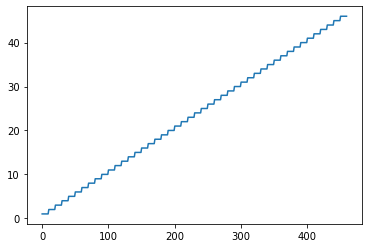

In [7]:
# drf_finer, mapindex, mapfact, cellindex = finegrid.finegrid(np.squeeze(ds.drF),np.squeeze(ds.drC),ds.drF.size)
drf_finer, mapindex, mapfact, cellindex = finegrid.finegrid(np.squeeze(ds.drF.sel(Z=slice(None,None))),
                                                            np.squeeze(ds.drC.sel(Zp1=slice(None,None))),
                                                            10)
plt.plot(cellindex)

In [17]:
v_in = ds.VVEL.where(ds.maskS!=0.).sel(YG=slice(-15,50+12**-1)
                                      ).drop(['maskS','drF','PHrefC','hFacS','iter'])
densy_in = rho2y.where(ds.maskS!=0.).sel(YG=slice(-15,50+12**-1)
                                        ).drop(['maskS','drF','PHrefC','hFacS','iter']) - 1e3
print(v_in, densy_in)

<xarray.DataArray 'VVEL' (time: 4, Z: 46, YG: 781, XC: 1000)>
dask.array<getitem, shape=(4, 46, 781, 1000), dtype=float32, chunksize=(1, 46, 781, 500), chunktype=numpy.ndarray>
Coordinates:
    dxG      (YG, XC) >f4 9243.555 9243.555 9243.555 ... 6144.707 6144.707
    rAs      (YG, XC) >f4 85639580.0 85639580.0 ... 56929412.0 56929412.0
    maskInS  (YG, XC) bool True True True True True ... True True True True True
    dyC      (YG, XC) >f4 9264.79 9264.79 9264.79 ... 9264.79 9264.79 9264.79
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * YG       (YG) >f4 -14.9583 -14.874967 -14.791634 ... 49.95837 50.041702
  * Z        (Z) >f4 -3.0467727 -9.454049 -16.363966 ... -5624.9517 -5875.141
  * time     (time) float64 1.703e+09 1.703e+09 1.703e+09 1.703e+09
Attributes:
    standard_name:  VVEL
    long_name:      Meridional Component of Velocity (m/s)
    units:          m/s
    mate:           UVEL <xarray.DataArray (time: 4, Z: 46, YG: 781, XC: 1000)>
dask.a

In [15]:
# Dsig = 11.
# tmp = np.log(np.linspace(np.exp(1),np.exp(10),101))
# tmp2 = tmp[1:] - tmp[1]
# tmp2 *= tmp2[-1]**-1 * Dsig
# print(tmp2)
# siglayers = 27. + tmp2
# plt.plot(siglayers, 'k.-')
Dsig = 9.7
nlayers = 43
# tmp = np.log(np.linspace(np.exp(1),np.exp(10),101))
# tmp2 = tmp[1:] - tmp[1]
# tmp2 *= tmp2[-1]**-1 * Dsig
# print(tmp2)
tmp = np.tanh(np.linspace(-2.,2.75,nlayers))
tmp += np.abs(tmp.min())
tmp *= tmp.max()**-1 * Dsig
# print(tmp)
siglayers = 27.5 + tmp
func = interp1d(range(1,nlayers+1), siglayers, fill_value='extrapolate')
sigp1layers = func(np.arange(.5,nlayers+1.5,1))

In [18]:
with ProgressBar():
    vdz = xr.apply_ufunc(layers_numpy, 
                        v_in,
                        densy_in,
                        kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                'mapindex':mapindex,'cellindex':cellindex,
                                'drf_finer':drf_finer},
                        dask='parallelized', 
                        input_core_dims=[['Z'],['Z']], 
                        output_core_dims=[['sig2lev']],
#                            output_core_dims=(['sig2lev']),
#                            exclude_dims=set(['Z']),
                        output_dtypes=[float,], output_sizes={'sig2lev':siglayers.size}
                        ).compute()
    
#     zetab0 = xr.apply_ufunc(layers_numpy, 
#                            (xr.ones_like(dens_in[0]) * ds.Z).where(ds.maskC!=0.).sel(Z=slice(None,None)),
# #                          v_in[0].sel(Z=slice(None,-1e3)),
#                            dens_in[0].sel(Z=slice(None,None)),
#                            kwargs={'thetalayers':siglayers,'mapfact':mapfact,
#                                    'mapindex':mapindex,'cellindex':cellindex,
#                                    'drf_finer':drf_finer},
#                            dask='parallelized', 
#                            input_core_dims=[['Z'],['Z']], 
#                            output_core_dims=[['sig2lev']],
# #                            output_core_dims=(['sig2lev']),
# #                            exclude_dims=set(['Z']),
#                            output_dtypes=[float,], output_sizes={'sig2lev':siglayers.size}
#                            ).compute()
vdz = vdz.assign_coords({'sig2lev':siglayers})
# zetab0 = zetab0.assign_coords({'sig2lev':siglayers})

[####################################    ] | 90% Completed | 11.1sWarning: theta_in may not be monotonically ascending/descending
[####################################    ] | 90% Completed | 11.2sWarning: theta_in may not be monotonically ascending/descending
[####################################    ] | 90% Completed | 11.4sWarning: theta_in may not be monotonically ascending/descending
[####################################    ] | 90% Completed | 11.5sWarning: theta_in may not be monotonically ascending/descending
[######################################  ] | 97% Completed | 35.8sWarning: theta_in may not be monotonically ascending/descending
[####################################### ] | 98% Completed | 36.0sWarning: theta_in may not be monotonically ascending/descending
[####################################### ] | 98% Completed | 36.2sWarning: theta_in may not be monotonically ascending/descending
[########################################] | 100% Completed |  1min  3.0s


IndexError: tuple index out of range

In [13]:
layers_numpy?

Signature:
layers_numpy(
    v_in,
    theta_in,
    thetalayers,
    mapfact,
    mapindex,
    cellindex,
    drf_finer,
)
Docstring: <no docstring>
File:      ~/miniconda3/envs/ensemble/lib/python3.7/site-packages/xlayers-0+untagged.18.g65af60b-py3.7-linux-x86_64.egg/xlayers/core.py
Type:      function
